In [1]:
import numpy as np
import pylab as pl
import math as ma
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import subprocess
import os
from scipy.fftpack import fft, ifft
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import mark_inset,inset_axes,InsetPosition

In [65]:
#load lightcurves
path_dir='/output/dir/path/'
bands='upperBand_lowerBand'

#data file format is mjd, flux, fluxerr
data1=np.loadtxt(path_dir+'higher_frequency_lc.txt')#higher frequency
data2=np.loadtxt(path_dir+'lower_frequency_lc.txt')#lower frequency

day_1=data1[:,0]
flux_1=data1[:,1]
fluxerr_1=data1[:,2]
day_2=data2[:,0]
flux_2=data2[:,1]
fluxerr_2=data2[:,2]


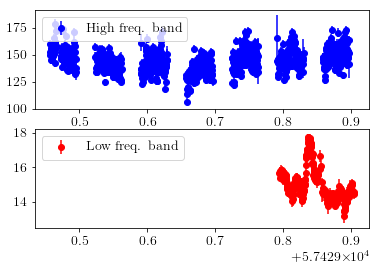

In [66]:
#plot lightcurves
fig=plt.figure()
ax=plt.subplot(211)
ax.errorbar(day_1,flux_1,yerr=fluxerr_1,marker='o',ls='',color='b',label='High freq. band')
ax2=plt.subplot(212,sharex=ax)
ax2.errorbar(day_2,flux_2,yerr=fluxerr_2,marker='o',ls='',color='r',label='Low freq. band')
ax.legend(loc='upper left')
ax2.legend(loc='upper left')

##Get ZDCF Fortran code [here](http://www.weizmann.ac.il/particle/tal/research-activities/software)

#NOTE: I modified original code to use commmand line arguments rather than user input

In [67]:
#run zdcf code and ML code using subprocess module

# range in seconds to look for lags
lowr,upr=['-5000','5000']

#set up lightcurve files in proper format
os.system('rm -rf '+path_dir+'inp1')
os.system('rm -rf '+path_dir+'inp1')
os.system('rm -rf '+path_dir+'zdcf_light.dcf')
os.system('rm -rf '+path_dir+'zdcf_light.lc1')
os.system('rm -rf '+path_dir+'zdcf_light.lc2')
tempFile = open(path_dir+'inp1','w')
tempFile2 = open(path_dir+'inp2','w')
if day_1[0]<=day_2[0]:
    comp=day_1[0]
else:
    comp=day_2[0]
for i in range(0,(len(day_1)-1)):
    tempFile.write(' {0} {1} {2}\n'.format((day_1[i]-comp)*(60*60*24.),flux_1[i],fluxerr_1[i]))
for i in range(0,(len(day_2)-1)):
    tempFile2.write(' {0} {1} {2}\n'.format((day_2[i]-comp)*(60*60*24.),flux_2[i],fluxerr_2[i]))
tempFile.close()
tempFile2.close()

#compiled fortran code run
print 'Running ZDCF...'
'''subprocess arguments:
-compiled code path
-type (1=auto, 2=cross)
-output files prefix 
-uniform sampling? (y or n)
-min points per bin (11 is default)
-omit zero lag? (y or n)
-mc sim number for errors
-input lc files'''
rc=subprocess.call(['/path/to/ccf_compiled_code','2', path_dir+'zdcf_light', 'n',\
                    '11', 'y', '100', path_dir+'inp1', path_dir+'inp2'])
print 'Running ML Peak Finder...'
rc3=subprocess.check_output(['/path/to/ml_compiled_code',\
                             path_dir+'zdcf_light.dcf',  lowr,upr])
print rc3

Running ZDCF...
Running ML Peak Finder...
 PLIKE V3.0 begins.
 Calculating ML in range   -5000.00000      to    5000.00000    

ZDCF peak at  +2.099E+03 r_max =  +0.426     , ZDCF C.O.M at  +2.201E+03
..................................


  #      lag         r         -dr        +dr    likelihood 
 --- ---------- ---------- ---------- ---------- ---------- 
  1 -4.951E+03  0.127      9.452E-02  9.338E-02   0.00    
  2 -4.891E+03  0.157      9.383E-02  9.241E-02   0.00    
  3 -4.831E+03  0.234      9.127E-02  8.924E-02   0.00    
  4 -4.771E+03  0.263      8.998E-02  8.772E-02   0.00    
  5 -4.711E+03  0.292      8.856E-02  8.611E-02   0.00    
  6 -4.651E+03  0.298      8.822E-02  8.572E-02   0.00    
  7 -4.591E+03  0.293      8.853E-02  8.607E-02   0.00    
  8 -4.531E+03  0.299      8.820E-02  8.570E-02   0.00    
  9 -4.471E+03  0.319      8.710E-02  8.447E-02   0.00    
 10 -4.411E+03  0.265      8.989E-02  8.762E-02   0.00    
 11 -4.351E+03  0.257      9.029E-02  8.809E-02   

In [68]:
#record lag output, all in seconds
lag_val=float(rc3[rc3.find('interval =')+10:rc3.find('interval =')+22])
lag_errL=float(rc3[rc3.find('interval =')+35:rc3.find('interval =')+50])
lag_errH=float(rc3[rc3.find('interval =')+24:rc3.find('interval =')+34])
data=np.loadtxt(path_dir+'zdcf_light.dcf')
time_lag=data[:,0]
cross_cor_coef=data[:,3]
peak_ind=np.where(np.logical_and(time_lag<lag_val+1.,time_lag>lag_val-1.))[0][0]
thresh=cross_cor_coef[peak_ind]
print 'Peak lag: ',"{0:.1f}".format(lag_val),'+',"{0:.1f}".format(lag_errH),"{0:.1f}".format(lag_errL),'sec'
print 'CCF Coefficient at peak: ', thresh

Peak lag:  2099.0 + 260.0 -60.5 sec
CCF Coefficient at peak:  0.4262


In [71]:
#simulations to estimate significance of ccf peaks--FFT,scramble phase,IFFT
def phaseScrambleTS(ts):
    fs = fft(ts)
    pow_fs = np.abs(fs) ** 2.
    phase_fs = np.angle(fs)
    phase_fsr = phase_fs.copy()
    if len(ts) % 2 == 0:
        phase_fsr_lh = phase_fsr[1:len(phase_fsr)/2]
    else:
        phase_fsr_lh = phase_fsr[1:len(phase_fsr)/2 + 1]
    np.random.shuffle(phase_fsr_lh)
    if len(ts) % 2 == 0:
        phase_fsr_rh = -phase_fsr_lh[::-1]
        phase_fsr = np.concatenate((np.array((phase_fsr[0],)), phase_fsr_lh,\
        np.array((phase_fsr[len(phase_fsr)/2],)),phase_fsr_rh))
    else:
        phase_fsr_rh = -phase_fsr_lh[::-1]
        phase_fsr = np.concatenate((np.array((phase_fsr[0],)), phase_fsr_lh, phase_fsr_rh))
    fsrp = np.sqrt(pow_fs) * (np.cos(phase_fsr) + 1j * np.sin(phase_fsr))
    tsrp = ifft(fsrp)
    return tsrp.real

nsim=1000

vals=[]
for i in range(0,nsim):
    flux_1=phaseScrambleTS(data_1[:,1])
    day_1=data_1[:,0]
    fluxerr_1=data_1[:,2]
    day_2=data_2[:,0]
    flux_2=data_2[:,1]
    fluxerr_2=data_2[:,2]
    os.system('rm -rf '+path_dir+'inp1_sim')
    os.system('rm -rf '+path_dir+'inp2_sim')
    os.system('rm -rf '+path_dir+'zdcf_light_sim.dcf')
    os.system('rm -rf '+path_dir+'zdcf_light_sim.lc1')
    os.system('rm -rf '+path_dir+'zdcf_light_sim.lc2')
    tempFile = open(path_dir+'inp1_sim','w')
    tempFile2 = open(path_dir+'inp2_sim','w')
    comp=day_1_sim[0]
    for i in range(0,(len(day_1_sim)-1)):
        tempFile.write(' {0} {1} {2}\n'.format((day_1_sim[i]-comp)*(60*60*24.),flux_1_sim[i],fluxerr_1_sim[i]))
    for i in range(0,(len(day_2_sim)-1)):
        tempFile2.write(' {0} {1} {2}\n'.format((day_2_sim[i]-comp)*(60*60*24.),flux_2_sim[i],fluxerr_2_sim[i]))
    tempFile.close()
    tempFile2.close()
    rc=subprocess.call(['/path/to/ccf_compiled_code','2', path_dir+'zdcf_light_sim', 'n',\
                        '11', 'y', '100', path_dir+'inp1_sim', path_dir+'inp2_sim'])
    data_sim=np.loadtxt(path_dir+'zdcf_light_sim.dcf')
    cross_cor_coef_sim=data[:,3]
    vals.append(cross_cor_coef_sim)

Percent above c= 0.4262 : 0.00670241286863


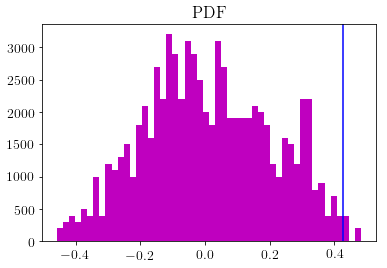

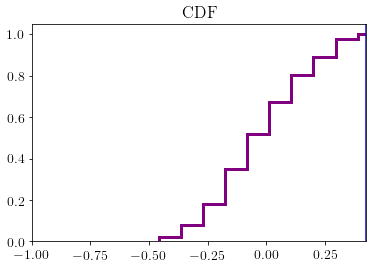

In [72]:
#p value for peak of CCF:

ccf_coeff_vals_sim=np.concatenate(vals)
pval=len([1 for i in ccf_coeff_vals_sim if i > thresh])/float(len(ccf_coeff_vals_sim))
print 'Percent above c=',thresh,':', pval

plt.figure()
plt.title('PDF')
plt.hist(ccf_coeff_vals_sim,bins=50,color='m')
plt.axvline(x=thresh,color='b')
plt.figure()
plt.title('CDF')
plt.hist(ccf_coeff_vals_sim, normed=True, cumulative=True,histtype='step', color='purple',lw=3)
plt.xlim(-1.,thresh)
plt.axvline(x=thresh,color='b')

In [ ]:
#alternatively the 95% and 99% confidence intervals
ppp=np.concatenate(vals)
x = np.sort(ppp)
y = np.arange(1,len(x)+1)/float(len(x))
plt.figure()
plt.plot(x,y)
plt.title('CCF')
p99=x[np.where(y==1-0.01)[0][0]]
p95=x[np.where(y==1-0.05)[0][0]]
print p99,p95

In [ ]:
##plot limits
#inset around peak
in_low=15*60
in_up=60*60.
#full plot
low=-75*60.
up=75*60.

Text(-50,-0.65,u'$\\tau_{\\rm lag}=35.0^{+4.3}_{-1.0}$ min')

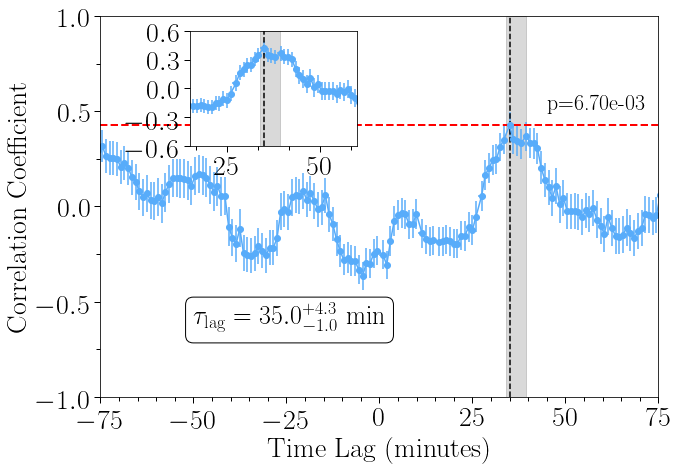

In [80]:
#plot ccf
data=np.loadtxt(path_dir+'zdcf_light.dcf')
time_lag=data[:,0]
time_lag_low=data[:,1]
time_lag_up=data[:,2]
cross_cor_coef=data[:,3]
cross_cor_coef_low=data[:,4]
cross_cor_coef_up=data[:,5]
filez=open(path_dir+'datafile_zdcf_'+bands+'.txt','w')
for ii in range(0,len(time_lag)):
    filez.write('{0} {1} {2} {3} {4} {5}\n'.format(time_lag[ii],time_lag_low[ii],time_lag_up[ii],\
                                                   cross_cor_coef[ii],cross_cor_coef_low[ii],\
                                                   cross_cor_coef_up[ii]))
filez.close()

fig2=plt.figure(figsize=(10,7))
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)
ax=plt.subplot(111)
ax.errorbar(time_lag/60.,cross_cor_coef,yerr=[cross_cor_coef_low,cross_cor_coef_up],\
            xerr=[time_lag_low/60.,time_lag_up/60.],marker='o',color='#58ACFA')
axins = inset_axes(ax,width="20%",height=2.,loc=2)
axins.errorbar(time_lag/60.,cross_cor_coef,yerr=[cross_cor_coef_low,cross_cor_coef_up],\
               xerr=[time_lag_low/60.,time_lag_up/60.],marker='o',color='#58ACFA')
axins.set_xlim(in_low/60.,in_up/60.)
axins.set_ylim(-0.6,0.6)
#axins.set_xticks([0,3,6])
axins.set_yticks([-0.6,-0.3,0,0.3,0.6])
axins.axvline(x=lag_val/60.,color='k',lw=1.5,ls='--')
axins.axvspan((lag_errL+lag_val)/60., (lag_errH+lag_val)/60., alpha=0.15, color='k')
axins.tick_params(axis='both',which='minor',length=4,width=1)
axins.tick_params(axis='both',which='major',labelsize=28,length=6,width=1)
axins.xaxis.set_minor_locator(AutoMinorLocator(3))
ip = InsetPosition(ax,[0.16,0.66,0.3,0.3])
axins.set_axes_locator(ip)
ax.set_xlabel('Time Lag (minutes)',fontsize=28)
ax.set_ylabel('Correlation Coefficient',fontsize=28)
ax.tick_params(axis='both',which='minor',length=4,width=1)
ax.tick_params(axis='both',which='major',labelsize=28,length=6,width=1)
ax.set_xlim(low/60.,up/60.)
ax.set_ylim(-1,1.)
ax.axvline(x=lag_val/60.,color='k',lw=1.5,ls='--')
ax.axvspan((lag_errL+lag_val)/60., (lag_errH+lag_val)/60., alpha=0.15, color='k')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.axhline(y=thresh,color='r',lw=2,ls='--')
ax.text(45,thresh+0.08,'p='+"{0:.2e}".format(pval),fontsize=22)
ax.text(-50,-0.65,'$\\tau_{\\rm lag}='+"{0:.1f}".format(lag_val/60.)+'^{+'+"{0:.1f}".format(lag_errH/60.)+'}_{-'+"{0:.1f}".format(abs(lag_errL)/60.)+'}$ min',size=26,color='k',bbox=dict(facecolor='w',alpha=1., edgecolor='k', boxstyle='round'))
##add anothe sig level if needed
#ax.text(45,xx+0.08,'p=',fontsize=22)
#ax.axhline(y=xx,color='r',lw=2,ls='--')
#plt.savefig(path_dir+'zdcf_'+bands+'_fig.pdf',format='pdf',bbox_inches='tight')